# 1. 에일리언 vs 프레데터 데이터셋
- https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images

- 케글 로그인 -> 우측 상단 계정클릭 -> your profile -> 중앙 account 클릭 -> api 항목에 create new api token -> kaggle.json이 다운댐

- kaggle.json
  - {"username":"pepidev","key":"982c120e8dea60a4a016b383ea4749f7"}

In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'pepidev'
os.environ['KAGGLE_KEY'] = '982c120e8dea60a4a016b383ea4749f7'

In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

 64% 9.00M/14.1M [00:00<00:00, 31.5MB/s]
100% 14.1M/14.1M [00:00<00:00, 41.7MB/s]


In [4]:
!unzip -q alien-vs-predator-images.zip

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentation)
- 원본 이미지(데이터)를 조작하여
원본과는 크고 작은 변화를 가진 이미지를 생성
- 일반적으로 모델 성능이 좋아짐
- 오버피팅 방지
- https://pytorch.org/vision/master/transforms.html

In [7]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224,224)),   # 이미지 파일 크기변경
        transforms.RandomAffine(0,shear=10, scale=(0.8,1.2)),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224,224)),   # 이미지 파일 크기변경
        transforms.ToTensor()
    ])
}

In [8]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [9]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [10]:
dataloaders = {
    'train' : DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation' : DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [11]:
print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


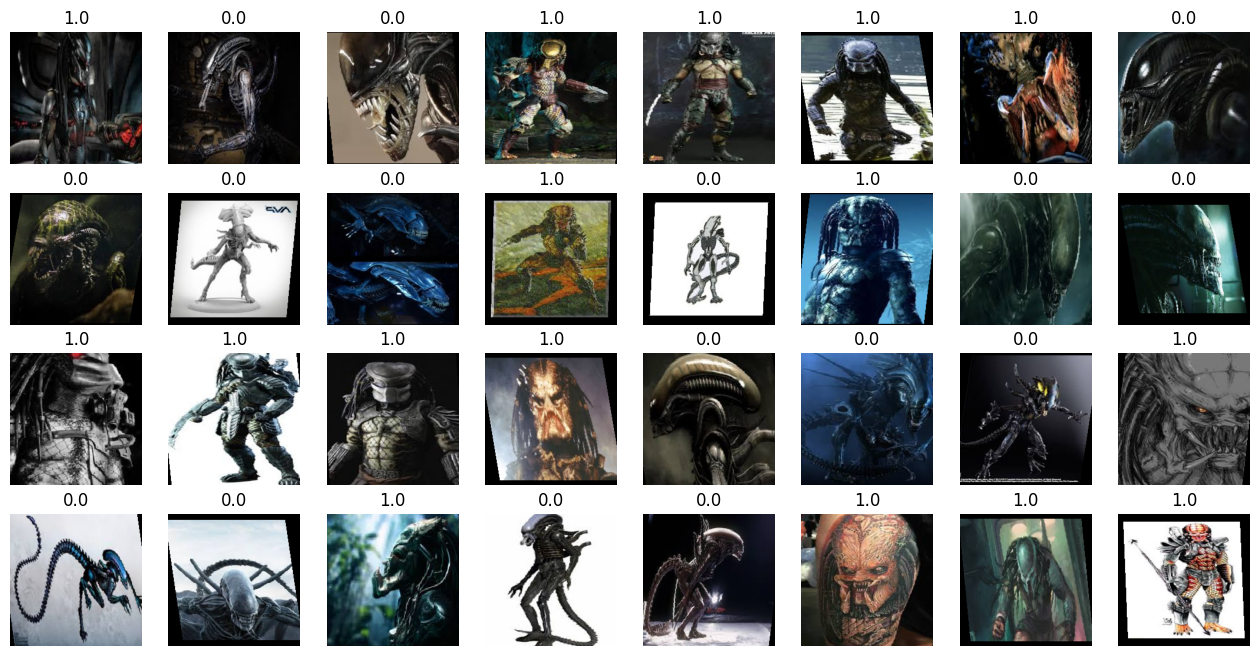

In [12]:
imgs, labels = next(iter(dataloaders['train']))

fig,axes = plt.subplots(4,8, figsize=(16,8))

for ax, img, label in zip(axes.flatten(),imgs, labels):
  # print(img.shape)
  ax.imshow(img.permute(1,2,0))
  ax.set_title(label.item())
  ax.set_title(label.item())
  ax.axis('off')

In [13]:
![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

/bin/bash: -c: line 1: syntax error near unexpected token `https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png'
/bin/bash: -c: line 1: `[](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)'


### 3-1 전이학습의 고려할 점
 - 크기 모델 크기는 배포할 위치와 방법에 따라 달라짐
 - 속도 정확도 하드웨워, 배지 크기의 같은 요소를 고려

 ![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

### 3-2. 사전 학습된 ResNet50 모델 사용

- [https://pytorch.org/vision/stable/models.html]
- ![](https://i.stack.imgur.com/gI4zT.png)


# 4. 이미지넷(ImageNet)
- 이미지 데이터베이스
- 1000개의 클래스로 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)

In [14]:
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 5. Freeze Layers
- 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정
- 출력 부분의 레이어(fc)를 다시 설정하여 분류에 맞게 변경

In [15]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# 학습
# optimizer : Adam
# epochs : 10
# train : Epoch 10/10 Loss: 0.1713 Accuracy: 92.47%
# validation : Epoch 10/10 Loss: 0.2579 Accuracy : 87.05%

# 학습
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}%')




train     : Epoch    1/10 Loss: 0.5725 Accuracy:  70.67%
validation: Epoch    1/10 Loss: 0.3760 Accuracy:  92.86%
train     : Epoch    2/10 Loss: 0.3528 Accuracy:  85.61%
validation: Epoch    2/10 Loss: 0.2577 Accuracy:  89.29%
train     : Epoch    3/10 Loss: 0.2521 Accuracy:  89.42%
validation: Epoch    3/10 Loss: 0.2928 Accuracy:  86.61%
train     : Epoch    4/10 Loss: 0.1897 Accuracy:  93.49%
validation: Epoch    4/10 Loss: 0.2169 Accuracy:  91.07%
train     : Epoch    5/10 Loss: 0.2085 Accuracy:  91.70%
validation: Epoch    5/10 Loss: 0.3194 Accuracy:  86.61%
train     : Epoch    6/10 Loss: 0.2219 Accuracy:  90.64%
validation: Epoch    6/10 Loss: 0.1988 Accuracy:  92.41%
train     : Epoch    7/10 Loss: 0.1696 Accuracy:  93.89%
validation: Epoch    7/10 Loss: 0.1877 Accuracy:  92.41%
train     : Epoch    8/10 Loss: 0.1464 Accuracy:  94.47%
validation: Epoch    8/10 Loss: 0.2852 Accuracy:  87.95%
train     : Epoch    9/10 Loss: 0.1930 Accuracy:  92.12%
validation: Epoch    9/10 Loss:

In [17]:
from PIL import Image

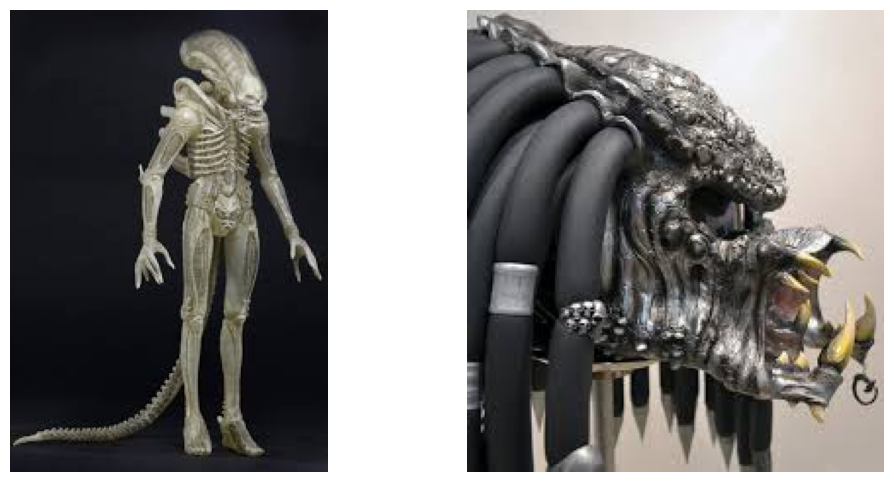

In [18]:
img1 = Image.open('/content/alien_vs_predator_thumbnails/data/validation/alien/19.jpg')
img2 = Image.open('/content/alien_vs_predator_thumbnails/data/validation/predator/20.jpg')

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [19]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [20]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [21]:
y_pred = model(test_batch)
y_pred

tensor([[0.1725],
        [0.9042]], device='cuda:0', grad_fn=<SigmoidBackward0>)

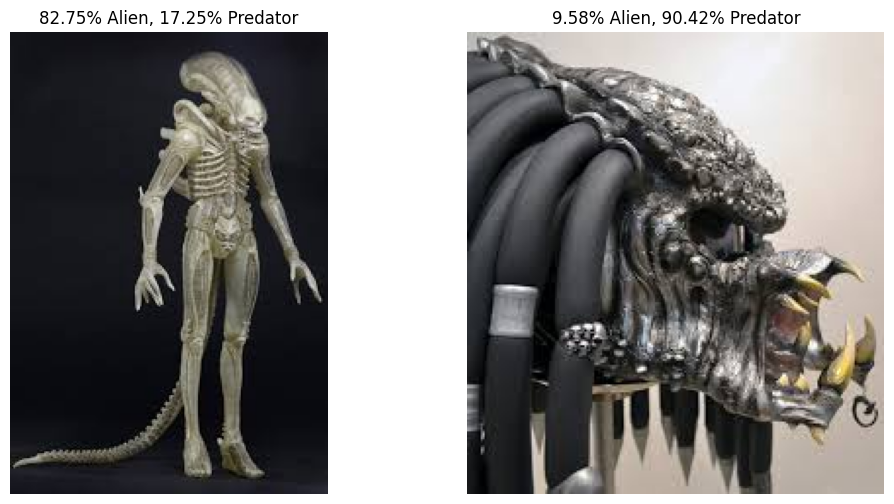

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()